<a href="https://colab.research.google.com/github/rubanzasilva/flood_probability/blob/dev/s04e05_fastai_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In this notebook, i have used  AutoGluon, which is an automated machine learning framework that promises to help you build fast and accurate ML models in three lines of code.

I shall put that to the test and compare it with my more manual process from my previous notebook located [here](https://www.kaggle.com/code/rubanzasilva/s04e05-fastai).

In [5]:
#hide

#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#!pip install fastkaggle
#!pip install optuna_distributed


In [4]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp
import optuna
#import optuna_distributed

from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [8]:
!ls 

In [ ]:
#set_seed(42)

In [ ]:
path = Path('playground-series-s4e5/')
path

In [ ]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv(path/'flood.csv')

In [ ]:
original_df.shape,train_df.shape

In [ ]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape

In [ ]:
train_df.shape,test_df.shape

In [ ]:
#train_df.hist(figsize=(20,15));

In [ ]:
%%time

predictor = TabularPredictor(label='FloodProbability').fit(train_data=train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240513_113151"

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.

	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):

	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.

	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.

	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.

	presets='medium_quality' : Fast training time, ideal for initial prototyping.


	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.

Beginning AutoGluon training ...

AutoGluon will save models to "AutogluonModels/ag-20240513_113151"

===============

[1000]	valid_set's rmse: 0.0199416

[2000]	valid_set's rmse: 0.0198346

[3000]	valid_set's rmse: 0.0197893

[4000]	valid_set's rmse: 0.0197668

[5000]	valid_set's rmse: 0.0197485

[6000]	valid_set's rmse: 0.0197356

[7000]	valid_set's rmse: 0.0197272

[8000]	valid_set's rmse: 0.0197224

[9000]	valid_set's rmse: 0.0197191

[10000]	valid_set's rmse: 0.019711


	-0.0197	 = Validation score   (-root_mean_squared_error)

	896.53s	 = Training   runtime

	15.26s	 = Validation runtime

Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0198579

[2000]	valid_set's rmse: 0.0197987

[3000]	valid_set's rmse: 0.0197629

[4000]	valid_set's rmse: 0.0197453

[5000]	valid_set's rmse: 0.0197325

[6000]	valid_set's rmse: 0.0197309

[7000]	valid_set's rmse: 0.019733

[8000]	valid_set's rmse: 0.0197366


	-0.0197	 = Validation score   (-root_mean_squared_error)

	664.37s	 = Training   runtime

	6.13s	 = Validation runtime

Fitting model: RandomForestMSE ...

	-0.0342	 = Validation score   (-root_mean_squared_error)

	3121.59s	 = Training   runtime

	0.99s	 = Validation runtime

Fitting model: CatBoost ...


In [ ]:
predictions = predictor.predict(test_df)

In [ ]:
predictions.shape

NameError: name 'predictions' is not defined

In [ ]:
predictor.evaluate(train_df)

{'root_mean_squared_error': -0.018936624517170795,
 'mean_squared_error': -0.0003585957481043141,
 'mean_absolute_error': -0.014903989475112229,
 'r2': 0.8620955063143817,
 'pearsonr': 0.928543929859238,
 'median_absolute_error': -0.011987644433975209}

In [ ]:
#predictor.leaderboard(train_df)

KeyboardInterrupt: 

In [ ]:
test_df['Rings'] = predictions
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "auto gluom  "

Using Full Dataset

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.009120108559727669, valley=0.0003981071640737355)

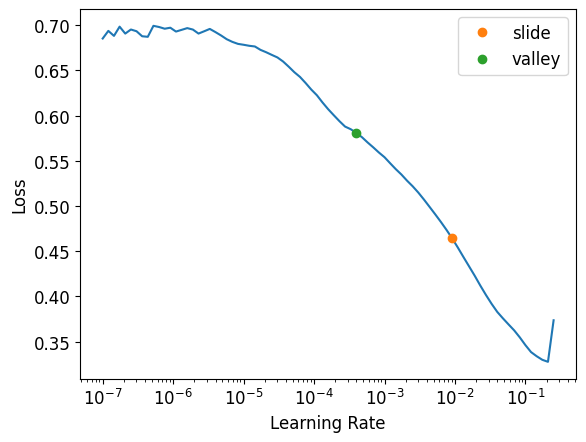

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(20,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000621,0.000525,0.797963,03:39
1,0.000507,0.000407,0.843425,03:38
2,0.000547,0.000416,0.840192,03:36
3,0.000553,0.000420,0.838580,03:36
4,0.000590,0.000538,0.793021,03:33
5,0.000624,0.000670,0.742360,03:34
6,0.000555,0.000559,0.784870,03:35
7,0.000531,0.000766,0.705548,03:36
8,0.000579,0.000493,0.810221,03:38
9,0.000539,0.000432,0.833939,03:32


CPU times: user 1h 9min 32s, sys: 30.7 s, total: 1h 10min 2s

Wall time: 1h 11min 24s


In [ ]:
#learn.fit_one_cycle(5,0.02)
%%time
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


CPU times: user 2min 17s, sys: 955 ms, total: 2min 18s

Wall time: 2min 20s


In [ ]:
#0.02 original dataset
r2_score(y_test,nn_preds_x)

0.8596201479670931

In [ ]:
dl = learn.dls.test_dl(test_df)
def ensemble():
  learn = tabular_learner(dls, metrics=mae)
  with learn.no_bar(), learn.no_logging():
    learn.fit(7, 0.005)
  return learn.get_preds(dl=dl)[0]

learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds_x = ens_preds.squeeze(1)
ens_preds_x.shape

torch.Size([745305])

In [ ]:
#ens_preds_y = ensemble()

In [ ]:
dl = learn.dls.test_dl(test_df)
def ensemble():
  learn = tabular_learner(dls, metrics=mae)
  with learn.no_bar(), learn.no_logging():
    learn.fit(7, 0.005)
  return learn.get_preds()[0]

learns = [ensemble() for _ in range(5)]

In [ ]:
#nn_preds_x.shape,ens_preds.shape,z.shape

In [ ]:
target_preds = ens_preds

test_df['Rings'] = target_preds
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,1117957,0.572660
1,1117958,0.458013
2,1117959,0.454228
3,1117960,0.467618
4,1117961,0.465604


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "ens preds  "


100% 13.2M/13.2M [00:00<00:00, 19.8MB/s]

Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8610875723288202

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8596201479670931

In [ ]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,1117957,0.572530
1,1117958,0.457642
2,1117959,0.455602
3,1117960,0.470247
4,1117961,0.469744


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "nn preds  "


100% 13.2M/13.2M [00:00<00:00, 15.9MB/s]

Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!rm submission.csv

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8610875723288202

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8609544681285392

In [ ]:
#0.008 with original dataset
r2_score(y_test,nn_preds_x)

0.8531591084930723

In [ ]:
#0.008, no original dataset
r2_score(y_test,nn_preds_x)

0.8596047522511752

In [ ]:
#0.05 no original dataset
r2_score(y_test,nn_preds_x)

0.8495222993640157

In [ ]:
#0.05 no original dataset
r2_score(y_test,nn_preds_x)

0.8609544681285392

In [ ]:
learn.export('models/fp_colab_model.pkl')

In [ ]:
!ls models

fp_colab_model.pkl


In [ ]:
learn.load('fp_colab_model.pkl')

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submision.csv', 'nn preds', comp)

# AutoGluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor(label='FloodProbability').fit(train_data=train_df)
predictions = predictor.predict(test_df)

ImportError: cannot import name '_is_pandas_df' from 'sklearn.utils' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py)

# Random Forest Baseline

In [ ]:
%%time
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=10)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

CPU times: user 7min 16s, sys: 1.05 s, total: 7min 17s

Wall time: 7min 27s


0.6037340079879046

# Optimize Params with Optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)

# CatBoost

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [ ]:
print(study_catboost.best_params)

{'learning_rate': 0.2916627098129582, 'depth': 8, 'random_strength': 1}


In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=8, learning_rate=  0.2916627098129582, random_strength=1)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 7min 18s, sys: 4.62 s, total: 7min 23s

Wall time: 4min 43s


0.851094987628713

In [ ]:
r2_score(y_test,cat_preds_x)

NameError: name 'cat_preds_x' is not defined

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.08, random_strength=27)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 16min 53s, sys: 4.82 s, total: 16min 58s

Wall time: 10min 6s


0.8484108713271834

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.08, random_strength=27)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 16min 52s, sys: 5.05 s, total: 16min 57s

Wall time: 10min 10s


0.8484108713271834

In [ ]:
%%time

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

# Create a study
study_catboost = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_catboost = optuna_distributed.from_study(study_catboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_catboost.optimize(objective_catboost, n_trials=100, n_jobs=num_parallel_jobs)

print(study_catboost.best_params)

In [ ]:
%%time
def objective(trial):
  model = CatBoostRegressor(
      iterations=trial.suggest_int("iterations", 1000, 3000),
      learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
      colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
      min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
      depth=trial.suggest_int("depth", 4, 15),
      l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
      verbose=False,
      random_state=27
      )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return np.sqrt(r2_score(y_test, y_pred))


 #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)



CPU times: user 9 µs, sys: 0 ns, total: 9 µs

Wall time: 12.9 µs


In [ ]:
 %%time
 optuna.logging.set_verbosity(optuna.logging.WARNING)

 sampler = optuna.samplers.TPESampler(seed=27)
 study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
 study.optimize(objective, n_trials=30)



In [ ]:
 print("Number of finished trials: ", len(study.trials))
 print("Best trial:")
 trial = study.best_trial
 print("  Value: ", trial.value)
 print("  Params: ")

 for key, value in trial.params.items():
     print(f"    {key}: {value}")
 print()

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat_boost"


100% 13.2M/13.2M [00:01<00:00, 9.87MB/s]

Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data

'kaggle (1).json'   models	  playground-series-s4e5.zip


# XGBoost

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)

[I 2024-05-08 21:34:25,097] A new study created in memory with name: no-name-8ae3b642-30df-4721-b8b7-f3dbb30d5a76

[I 2024-05-08 21:34:38,452] Trial 0 finished with value: 0.0323333740234375 and parameters: {'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.0767006457556867, 'subsample': 0.7884890645620555}. Best is trial 0 with value: 0.0323333740234375.

[I 2024-05-08 21:35:13,275] Trial 1 finished with value: 0.021586356684565544 and parameters: {'n_estimators': 164, 'max_depth': 10, 'learning_rate': 0.14377450978725867, 'subsample': 0.8482468806222986}. Best is trial 1 with value: 0.021586356684565544.

[I 2024-05-08 21:35:36,705] Trial 2 finished with value: 0.02356773428618908 and parameters: {'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.28199233688931646, 'subsample': 0.28153556236937083}. Best is trial 1 with value: 0.021586356684565544.

[I 2024-05-08 21:35:50,018] Trial 3 finished with value: 0.045142143964767456 and parameters: {'n_estimators': 103, 'max_dep

{'n_estimators': 197, 'max_depth': 4, 'learning_rate': 0.1818695751227044, 'subsample': 0.39774994666482544}


In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8328108326764126

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_xgboost = optuna_distributed.from_study(study_xgboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_xgboost.optimize(objective_xgboost, n_trials=100, n_jobs=num_parallel_jobs)


print(study_xgboost.best_params)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 767, max_depth=13, learning_rate=0.22472048294428892, subsample= 0.8936985751131682, min_child_weight=10, gamma=8.58031910185836e-07, colsample_bytree=0.04050040446078567, reg_alpha=0.16025160863896398, reg_lambda=6.875124639971543e-08, random_state=27)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8459411327560431

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat_boost"


100% 13.2M/13.2M [00:01<00:00, 8.87MB/s]

400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (12 hours from now).


# Light GBM

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

[I 2024-05-08 22:09:51,585] A new study created in memory with name: no-name-af8b0f7a-bd8c-403c-bddf-9dd53f48a69c


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188081 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 368

[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20

[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 22:10:14,977] Trial 0 finished with value: 0.02122505765570546 and parameters: {'num_leaves': 29, 'learning_rate': 0.22104258573435334, 'n_estimators': 132}. Best is trial 0 with value: 0.02122505765570546.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185583 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 368

[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20

[LightGBM] [Info] Start training from score 0.504235


[W 2024-05-08 22:10:22,624] Trial 1 failed with parameters: {'num_leaves': 48, 'learning_rate': 0.06196305605637638, 'n_estimators': 172} because of the following error: KeyboardInterrupt().

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial

    value_or_values = func(trial)

  File "<ipython-input-27-c89ead468ece>", line 8, in objective_lgbm

    model.fit(X_train, y_train)

  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit

    super().fit(

  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit

    self._Booster = train(

  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 276, in train

    booster.update(fobj=fobj)

  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 3658, in update

    _safe_call(_LIB.LGBM_BoosterUpdateOneIter(

KeyboardInterrupt

[W 2024-05-08 22:10:22,632] Trial 

KeyboardInterrupt: 

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180857 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 370

[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20

[LightGBM] [Info] Start training from score 0.504451


0.8353827730240946

In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)


print(study_lgbm.best_params)

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data

'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
mse = mean_absolute_error(y_test,cat_preds_x)
rmse = np.sqrt(mse)
rmse

0.12580042

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat boost"


100% 13.2M/13.2M [00:01<00:00, 9.79MB/s]

Successfully submitted to Regression with a Flood Prediction Dataset

# Model Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds.shape

torch.Size([223591])

In [ ]:
#for r2_Score testing
general_preds = (xgb_preds_x + cat_preds_x + nn_preds_m)/3
general_preds.shape

torch.Size([233591])

In [ ]:
#for r2_Score testing
general_preds = (cat_preds_x + nn_preds_m)/2
general_preds.shape

torch.Size([233591])

In [ ]:
r2_score(y_test,general_preds)

0.858287865688015

In [ ]:
r2_score(y_test,general_preds)

0.8582584096219742

In [ ]:
general_preds

tensor([0.3679, 0.5352, 0.5139,  ..., 0.5351, 0.4667, 0.4714])

In [ ]:
#use for submission
general_preds = ( cat_preds + nn_preds_y)/2
general_preds

tensor([0.5736, 0.4575, 0.4550,  ..., 0.6213, 0.5514, 0.5128])

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

catboost_info  kaggle.json  playground-series-s4e5	sample_data

gdrive	       models	    playground-series-s4e5.zip


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "general preds ( cat_preds + nn_preds_y )"


100% 13.2M/13.2M [00:00<00:00, 14.1MB/s]

Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
# Check if the KAGGLE_USERNAME environment variable is set
#iskaggle = 'KAGGLE_USERNAME' in os.environ

if not iskaggle:
    push_notebook('rubanzasilva', 's04e05_fastai_exp1',
                 title='Flood Probability: s04e05_fastai_exp1',
                 file='s04e05_fastai_exp1.ipynb',
                 competition=comp, private=False, gpu=True)


NameError: name 'push_notebook' is not defined

In [ ]:
if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)

NameError: name 'iskaggle' is not defined

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

KeyboardInterrupt: 

In [ ]:
r2_score(y_test,xgb_preds_x)

0.7817602531907657

In [ ]:
mse = mean_absolute_error(y_test, xgb_preds_x)
rmse = np.sqrt(mse)
rmse

0.13967574

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177988 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 367

[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20

[LightGBM] [Info] Start training from score 0.504491


0.8235475438046409

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data

'kaggle (1).json'   models	  playground-series-s4e5.zip


In [ ]:
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability
0,1117957,0.575180
1,1117958,0.463337
2,1117959,0.450641
3,1117960,0.460754
4,1117961,0.461083
...,...,...
745300,1863257,0.484195
745301,1863258,0.457408
745302,1863259,0.634439
745303,1863260,0.566786


In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data

'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "lgb preds"


100% 13.2M/13.2M [00:00<00:00, 17.0MB/s]

Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = rf_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability,Rings
0,1117957,0.5,0.568910
1,1117958,0.5,0.454981
2,1117959,0.5,0.450971
3,1117960,0.5,0.471085
4,1117961,0.5,0.470031
...,...,...,...
745300,1863257,0.5,0.475079
745301,1863258,0.5,0.446771
745302,1863259,0.5,0.616611
745303,1863260,0.5,0.546384


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "rf_preds"

In [ ]:
!ls

In [ ]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [ ]:
general_preds

tensor([1.7166, 1.3715, 1.3782,  ..., 1.8436, 1.6442, 1.5364])